In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
from scipy import stats
import sklearn
from sklearn.neighbors import KernelDensity
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
main_path = Path('../olympic-historical-dataset')
list(main_path.glob('*'))

[PosixPath('../olympic-historical-dataset/Olympic_Athlete_Event_Results.csv'),
 PosixPath('../olympic-historical-dataset/Olympics_Games.csv'),
 PosixPath('../olympic-historical-dataset/Olympics_Country.csv'),
 PosixPath('../olympic-historical-dataset/Olympic_Games_Medal_Tally.csv'),
 PosixPath('../olympic-historical-dataset/Olympic_Athlete_Bio.csv'),
 PosixPath('../olympic-historical-dataset/Olympic_Results.csv')]

In [3]:
result_df = pd.read_csv(main_path / 'Olympic_Results.csv')
result_df.head()

,result_id,event_title,edition,edition_id,sport,sport_url,result_date,result_location,result_participants,result_format,result_detail,result_description
0,30359,"Super-Heavyweight (>105 kilograms), Men",2004 Summer Olympics,26,Weightlifting,/editions/26/sports/WLF,"25 August 2004 — 16:30 (B), 20:00 (A)","Olympiako Gymnastirio Arsis Varon Nikaias, Nikaia",17 from 15 countries,Total of best lifts in snatch and clean & jerk...,na,"Not so much a competition as a coronation, the..."
1,1626,"Giant Slalom, Women1",1998 Winter Olympics,46,Snowboarding,/editions/46/sports/SBD,9 February 1998,"Mt. Yakebitai, Shiga Kogen, Yamanouchi",31 from 14 countries,"Two runs, total time determined placement.",Gates: 38 / 36Length: 936 mStart Altitude: 196...,The women’s giant slalom was postponed one day...
2,76,"Singles, Men",1976 Winter Olympics,40,Luge,/editions/40/sports/LUG,4 – 7 February 1976,"Kunsteis-Bob- und Rodelbahn, Igls",43 from 15 countries,"Four runs, total time determined placement.",Curves: 14Length: 1220 mStart Altitude: ?Verti...,"Once more, the competitors from East and West ..."
3,962,"1,500 metres, Men",1928 Winter Olympics,30,Speed Skating,/editions/30/sports/SSK,14 February 1928 — 9:00,"Olympia-Eisstadion Badrutts Park, St. Moritz",30 from 14 countries,na,na,There was little doubt that the Olympic 1500 m...
4,258824,"Canadian Singles, Slalom, Men",2008 Summer Olympics,53,Canoe Slalom,/editions/53/sports/CSL,11 – 12 August 2008,"Shunyi Aolinpike Shuishang Gongyuan, Mapo, Shunyi",16 from 16 countries,na,na,Two former Olympic champions in the C-1 slalom...


In [4]:
event_df = pd.read_csv(main_path / 'Olympic_Athlete_Event_Results.csv')
event_df.head()

,edition,edition_id,country_noc,sport,event,result_id,athlete,athlete_id,pos,medal,isTeamSport
0,1908 Summer Olympics,5,ANZ,Athletics,"100 metres, Men",56265,Ernest Hutcheon,64710,DNS,NaN,False
1,1908 Summer Olympics,5,ANZ,Athletics,"400 metres, Men",56313,Henry Murray,64756,DNS,NaN,False
2,1908 Summer Olympics,5,ANZ,Athletics,"800 metres, Men",56338,Harvey Sutton,64808,3 h8 r1/2,NaN,False
3,1908 Summer Olympics,5,ANZ,Athletics,"800 metres, Men",56338,Guy Haskins,922519,DNS,NaN,False
4,1908 Summer Olympics,5,ANZ,Athletics,"800 metres, Men",56338,Joseph Lynch,64735,DNS,NaN,False


In [5]:
len(event_df)

316834

In [10]:
event_df['sport'].unique()

array(['Athletics', 'Boxing', 'Diving', 'Rugby', 'Shooting', 'Swimming',
       'Rowing', 'Tennis', 'Artistic Gymnastics', 'Cycling Track',
       'Fencing', 'Wrestling', 'Art Competitions', 'Cycling Road',
       'Artistic Swimming', 'Judo', 'Sailing', 'Weightlifting',
       'Taekwondo', 'Archery', 'Golf', 'Bobsleigh', 'Skeleton',
       'Canoe Sprint', 'Cycling Mountain Bike', 'Modern Pentathlon',
       'Handball', 'Triathlon', 'Alpine Skiing', 'Basketball',
       'Roller Hockey', 'Beach Volleyball', 'Hockey', 'Football',
       'Badminton', 'Figure Skating', 'Rhythmic Gymnastics',
       'Equestrian Jumping', 'Wushu', 'Canoe Slalom', 'Karate',
       'Cross Country Skiing', 'Freestyle Skiing', 'Speed Skating',
       'Luge', 'Table Tennis', 'Biathlon', 'Snowboarding',
       'Equestrian Eventing', 'Equestrian Dressage', 'Volleyball',
       'Trampolining', 'Marathon Swimming', 'Nordic Combined',
       'Ski Jumping', 'Ice Hockey', 'Short Track Speed Skating',
       'Cycling BMX 

In [11]:
(result_df['sport'] == 'Figure Skating').sum(), (event_df['sport'] == 'Figure Skating').sum()

(np.int64(96), np.int64(2878))

In [12]:
df = pd.merge(event_df, result_df, how='left', on='result_id', suffixes=('', '_duplicate'))
df = df.drop(columns=[col for col in df.columns if col.endswith('_duplicate')])
figure_skating_df = df[df['sport'] == 'Figure Skating']
figure_skating_df.head()

,edition,edition_id,country_noc,sport,event,result_id,athlete,athlete_id,pos,medal,isTeamSport,event_title,sport_url,result_date,result_location,result_participants,result_format,result_detail,result_description
1867,1998 Winter Olympics,46,AZE,Figure Skating,"Singles, Men",14168,Igor Pashkevich,96229,16,NaN,False,"Singles, Men",/editions/46/sports/FSK,12 – 14 February 1998,"White Ring, Nagano",29 from 24 countries,"In each section, skaters were ranked on Ordina...",na,"Since Lillehammer, Elvis Stojko (CAN), silver ..."
1868,1998 Winter Olympics,46,AZE,Figure Skating,"Singles, Women",14189,Yuliya Vorobyova,82967,16,NaN,False,"Singles, Women",/editions/46/sports/FSK,18 – 20 February 1998,"White Ring, Nagano",28 from 21 countries,"In each section, skaters were ranked on Ordina...",na,Michelle Kwan had a chance to be on the 1994 U...
1869,1998 Winter Olympics,46,AZE,Figure Skating,"Pairs, Mixed",14210,Inga Rodionova,100207,18,NaN,True,"Pairs, Mixed",/editions/46/sports/FSK,8 – 10 February 1998,"White Ring, Nagano",40 from 14 countries,The pairs were ranked on Ordinal Placement for...,na,Artur Dmitriyev (RUS) had won the pairs gold m...
1870,1998 Winter Olympics,46,AZE,Figure Skating,"Pairs, Mixed",14210,Aleksandr Anishchenko,100208,18,NaN,True,"Pairs, Mixed",/editions/46/sports/FSK,8 – 10 February 1998,"White Ring, Nagano",40 from 14 countries,The pairs were ranked on Ordinal Placement for...,na,Artur Dmitriyev (RUS) had won the pairs gold m...
1904,2002 Winter Olympics,47,AZE,Figure Skating,"Singles, Men",14274,Sergey Rylov,101980,24,NaN,False,"Singles, Men",/editions/47/sports/FSK,12 – 14 February 2002,"Salt Lake Ice Center, Salt Lake City, Utah",28 from 20 countries,"In each section, skaters were ranked on Ordina...",na,"The co-favorites were the two Russians, Yevgen..."


In [13]:
pd.Series(figure_skating_df['edition'].unique()).sort_values().values

array(['1908 Summer Olympics', '1920 Summer Olympics',
       '1924 Winter Olympics', '1928 Winter Olympics',
       '1932 Winter Olympics', '1936 Winter Olympics',
       '1948 Winter Olympics', '1952 Winter Olympics',
       '1956 Winter Olympics', '1960 Winter Olympics',
       '1964 Winter Olympics', '1968 Winter Olympics',
       '1972 Winter Olympics', '1976 Winter Olympics',
       '1980 Winter Olympics', '1984 Winter Olympics',
       '1988 Winter Olympics', '1992 Winter Olympics',
       '1994 Winter Olympics', '1998 Winter Olympics',
       '2002 Winter Olympics', '2006 Winter Olympics',
       '2010 Winter Olympics', '2014 Winter Olympics',
       '2018 Winter Olympics', '2022 Winter Olympics'], dtype=object)

In [17]:
figure_skating_df['got-medal'] = (~ figure_skating_df['medal'].isna())
medal_count = figure_skating_df.groupby('country_noc')['got-medal'].sum().sort_values(ascending=False)
medal_count.head(30)

/var/folders/l4/xcb152_d5v51k4kx19t42f0w0000gn/T/ipykernel_41372/2954525174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  figure_skating_df['got-medal'] = (~ figure_skating_df['medal'].isna())


country_noc
USA    101
CAN     65
RUS     52
URS     44
ROC     43
AUT     25
FRA     22
GER     21
JPN     20
GBR     20
CHN     16
GDR     14
HUN     12
SWE     10
EUN      9
NOR      7
TCH      5
FIN      4
ITA      3
NED      3
FRG      3
BEL      3
SUI      3
UKR      3
KOR      2
KAZ      1
ESP      1
SLO      0
TUR      0
SCG      0
Name: got-medal, dtype: int64

<Axes: xlabel='country_noc'>

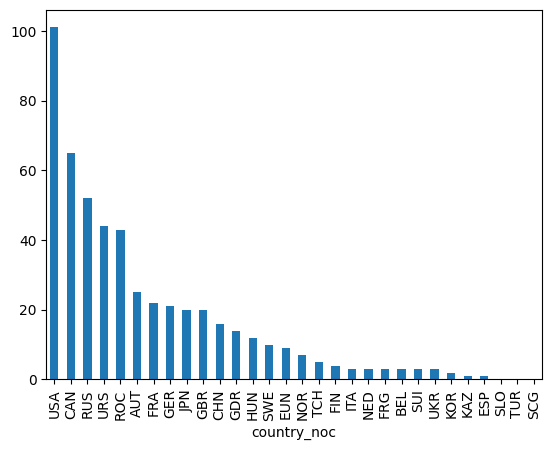

In [24]:
medal_count.head(30).plot.bar()

In [19]:
participated_countries = figure_skating_df[figure_skating_df['edition'].str.fullmatch('2014 Winter Olympics')]['country_noc'].unique()
participated_countries

array(['AZE', 'CZE', 'GEO', 'EST', 'BEL', 'BRA', 'ISR', 'AUT', 'KAZ',
       'LTU', 'AUS', 'PHI', 'CAN', 'GER', 'SVK', 'JPN', 'RUS', 'NOR',
       'KOR', 'ROU', 'CHN', 'UZB', 'GBR', 'ITA', 'FRA', 'TUR', 'UKR',
       'ESP', 'SWE', 'USA'], dtype=object)

In [25]:
sochi_country_medal_count = medal_count[participated_countries].sort_values(ascending=False)
sochi_country_medal_count

country_noc
USA    101
CAN     65
RUS     52
AUT     25
FRA     22
GER     21
GBR     20
JPN     20
CHN     16
SWE     10
NOR      7
UKR      3
ITA      3
BEL      3
KOR      2
KAZ      1
ESP      1
UZB      0
TUR      0
GEO      0
EST      0
ROU      0
LTU      0
CZE      0
SVK      0
BRA      0
ISR      0
PHI      0
AUS      0
AZE      0
Name: got-medal, dtype: int64

<Axes: xlabel='country_noc'>

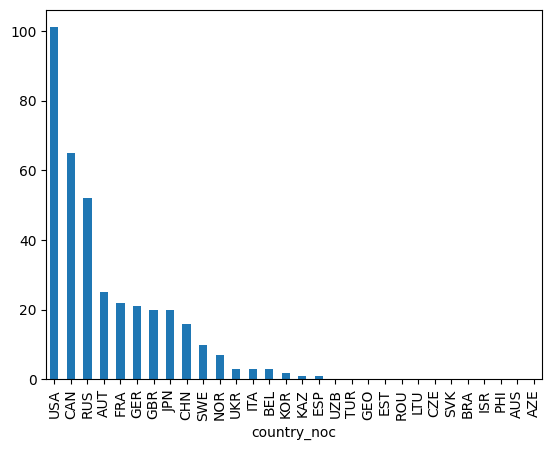

In [26]:
sochi_country_medal_count.plot.bar()

In [30]:
powerful_countries = sochi_country_medal_count[sochi_country_medal_count >= sochi_country_medal_count['JPN']].index
powerful_countries

Index(['USA', 'CAN', 'RUS', 'AUT', 'FRA', 'GER', 'GBR', 'JPN'], dtype='object', name='country_noc')

In [9]:
athlete_bio_df = pd.read_csv(main_path / 'Olympic_Athlete_Bio.csv')
athlete_bio_df.groupby('name')['athlete_id'].count().value_counts()

athlete_id
1     150251
2       2086
3        285
4         81
5         30
7          6
8          3
9          2
6          2
13         1
Name: count, dtype: int64